In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf

# Import and init h2o lib. Running on java
import h2o
from h2o.automl import H2OAutoML
h2o.init()

%matplotlib inline

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)


2023-11-12 13:36:37.297142: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-12 13:36:40.680699: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-11-12 13:36:40.681532: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.21" 2023-10-17; OpenJDK Runtime Environment (build 11.0.21+9-post-Debian-1deb11u1); OpenJDK 64-Bit Server VM (build 11.0.21+9-post-Debian-1deb11u1, mixed mode, sharing)
  Starting server from /opt/conda/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/tmp/tmpcj0crldw
  JVM stdout: /var/tmp/tmpcj0crldw/h2o_jupyter_started_from_python.out
  JVM stderr: /var/tmp/tmpcj0crldw/h2o_jupyter_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 days
H2O_cluster_name:,H2O_from_python_jupyter_utm6yr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.832 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [2]:
starting_directory = '.'

In [3]:
train_a = pd.read_parquet(f'{starting_directory}/A/train_targets.parquet')
train_b = pd.read_parquet(f'{starting_directory}/B/train_targets.parquet')
train_c = pd.read_parquet(f'{starting_directory}/C/train_targets.parquet')

In [4]:
X_train_estimated_a = pd.read_parquet(f'{starting_directory}/A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet(f'{starting_directory}/B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet(f'{starting_directory}/C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet(f'{starting_directory}/A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet(f'{starting_directory}/B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet(f'{starting_directory}/C/X_train_observed.parquet')

X_test_estimated_a = pd.read_parquet(f'{starting_directory}/A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet(f'{starting_directory}/B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet(f'{starting_directory}/C/X_test_estimated.parquet')

In [5]:
def fillNaN(data):
    new_data = []
    for df in data:
        for column in df.columns:
            df[column] = df[column].interpolate()
        new_data.append(df)
    return new_data

def quartersToHours(data):
    hourly_data = []
    for df in data:    
        df["year"] = df['date_forecast'].dt.year
        df["month"] = df['date_forecast'].dt.month
        df["day"] = df['date_forecast'].dt.day
        df["hour"] = df['date_forecast'].dt.hour
    
        group = df.groupby([df["year"], df["month"], df["day"], df["hour"]])  
        result = group.mean()
        result = result.reset_index()
    
        return_df = result.drop(['year', 'month', 'day', 'hour'], axis=1)
        
        hourly_data.append(return_df)

    return hourly_data


def appendLabels(train, val, labels):
    # Rename columns names to match
    val = val.assign(date_forecast=val.date_forecast.dt.round('H'))
    train = train.assign(date_forecast=train.date_forecast.dt.round('H'))

    labels = labels.rename(columns={'time': 'date_forecast'})
    
    joined_train = pd.merge(train, labels, how="inner", on="date_forecast")
    joined_val = pd.merge(val, labels, how="inner", on="date_forecast")

    return [joined_train, joined_val]

# Remove date columns
def removeNonNumeric(data):
    numeric_data = []
    for df in data:
        non_numeric_columns = df.select_dtypes(exclude='number').columns.tolist()
        df.drop(columns=non_numeric_columns, inplace=True)
        numeric_data.append(df)
    return numeric_data

def removeNaN(data):
    new_data = []
    for df in data:
        if 'pv_measurement' in df.columns:
            df = df.dropna(subset=['pv_measurement'])
        new_data.append(df)
    return new_data

In [6]:
A = [X_train_observed_a, X_train_estimated_a, X_test_estimated_a]
B = [X_train_observed_b, X_train_estimated_b, X_test_estimated_b]
C = [X_train_observed_c, X_train_estimated_c, X_test_estimated_c]

In [7]:
A = quartersToHours(A)
B = quartersToHours(B)
C = quartersToHours(C)

A[:2] = appendLabels(A[0], A[1], train_a)
B[:2] = appendLabels(B[0], B[1], train_b)
C[:2] = appendLabels(C[0], C[1], train_c)

A = fillNaN(A)
B = fillNaN(B)
C = fillNaN(C)

A = removeNonNumeric(A)
B = removeNonNumeric(B)
C = removeNonNumeric(C)

A = removeNaN(A)
B = removeNaN(B)
C = removeNaN(C)

In [8]:
class Window:
    def __init__(self, targets, window_size=100):
        self.targets = targets
        self.window_size = window_size

        self.start = 0
        self.end = self.window_size


    def get(self):
        return self.targets[self.start: self.end]

    def next(self):
        self.start += 1
        self.end += 1

    def hasNext(self):
        if self.end < len(self.targets):
            return True

        return False


def find_and_delete_constants(data):
    new_data = []
    for df in data:
        WINDOW_SIZE = 24

        window = Window(df["pv_measurement"], WINDOW_SIZE)

        constants = []

        while window.hasNext():
            if window.get().std() <= 0.1:
                constants.append((window.start, window.end))
            window.next()

        def extract_indices(ranges):
            return [start for start, _ in ranges]


        indices = extract_indices(constants)


        df = df.drop(indices)
        df = df.reset_index()
        df = df.drop(['index'], axis=1)

        new_data.append(df)
    return new_data

In [9]:
#A[:2] = find_and_delete_constants(A[:2])
#B[:2] = find_and_delete_constants(B[:2])
#C[:2] = find_and_delete_constants(C[:2])

In [10]:
def combineAttributes(data):
    new_data = []
    for df in data:
        df['global_rad:W'] = df['direct_rad:W'] + df['diffuse_rad:W']
        df['global_rad_1h:J'] = df['direct_rad_1h:J'] + df['diffuse_rad_1h:J']
        
        df['diffuse_rad_ult'] = df['diffuse_rad_1h:J'] + df['diffuse_rad:W']
        df['direct_rad_ult'] = df['direct_rad_1h:J'] + df['direct_rad:W']

        df['ult_attribute'] = df['direct_rad_ult'] + df['diffuse_rad_ult']
        
        new_data.append(df)
    return new_data

A = combineAttributes(A)
B = combineAttributes(B)
C = combineAttributes(C)

In [11]:
def createFeatures(data): #ALL CREATED FEATURES BY NOW PROVIDES BETTER SCORE
    new_data = []
    for df in data:
        top5 = ['absolute_humidity_2m:gm3', 'ceiling_height_agl:m', 'air_density_2m:kgm3', 'cloud_base_agl:m', 'sun_azimuth:d'] 
        seenCombos = []
        toCombine = [('effective_cloud_cover:p', 'clear_sky_energy_1h:J')]
        for elem in top5:
            for elem2 in top5:
                if {elem, elem2} not in seenCombos:
                    seenCombos.append({elem, elem2})
                    if elem != elem2:
                        toCombine.append((str(elem), str(elem2)))
        toClose = []
        for col in df.copy().columns:
            for col2 in df.copy().columns:
                if {str(col), str(col2)} not in seenCombos:
                    seenCombos.append({str(col), str(col2)})
                    if col != col2:
                        if abs(df[str(col)].corr(df[str(col2)])) >= 0.8:
                            if str(col)[:4] == str(col2)[:4]:
                                toClose.append((str(col), str(col2)))
                            elif str(col) in top5 or str(col2) in top5:
                                toCombine.append((str(col), str(col2)))

        created = []
        for i in range(len(toCombine)):
            df[toCombine[i][0] + '_' + toCombine[i][1]] = df[toCombine[i][0]] * df[toCombine[i][1]]
            created.append(toCombine[i][0] + '_' + toCombine[i][1])
        new_data.append(df)
    return new_data

#A = createFeatures(A)

print(all(elem.columns.tolist() == A[0].columns.tolist() for elem in A[:2]))

True


In [12]:
def makeFrame(data):
    new_data = []
    for df in data:
        hf = h2o.H2OFrame(df)
        new_data.append(hf)
    return new_data

A = makeFrame(A)
B = makeFrame(B)
C = makeFrame(C)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [13]:
# Running fit/training on train set with cross validation n=5
model_a = H2OAutoML(max_models = 10, seed = 1)
model_a.train(x = A[0].columns.remove('pv_measurement'), y = 'pv_measurement', training_frame = A[0])

AutoML progress: |
13:37:00.137: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

██
13:37:18.475: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]


13:37:20.167: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

███
13:37:35.310: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]


13:37:43.870: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

███
13:38:47.664: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]


13:39:00.608: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

██
13:39:12.269: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

█
13:39:27.463: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

█
13:39:34.970: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

██
13:40:49.912: _tr

key,value
Stacking strategy,cross_validation
Number of base models (used / total),5/10
# GBM base models (used / total),3/4
# XGBoost base models (used / total),2/3
# DRF base models (used / total),0/2
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


In [14]:
lb = model_a.leaderboard

# Showing best perforimg models
lb.head()

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_1_20231112_133700,398.263,158613,182,nan,158613
StackedEnsemble_BestOfFamily_1_AutoML_1_20231112_133700,402.227,161787,184.421,nan,161787
GBM_4_AutoML_1_20231112_133700,402.684,162155,183.871,nan,162155
GBM_3_AutoML_1_20231112_133700,407.521,166073,187.549,nan,166073
GBM_2_AutoML_1_20231112_133700,408.854,167162,188.617,nan,167162
GBM_1_AutoML_1_20231112_133700,419.996,176396,193.424,nan,176396
XRT_1_AutoML_1_20231112_133700,424.751,180413,194.83,0.599803,180413
DRF_1_AutoML_1_20231112_133700,425.713,181232,195.994,0.600301,181232
XGBoost_3_AutoML_1_20231112_133700,432.693,187223,204.951,nan,187223
XGBoost_2_AutoML_1_20231112_133700,443.942,197084,203.997,nan,197084


In [ ]:
validation_a = model_a.predict(A[1].drop('snow_density:kgm3'))
#validation_b = aml.predict(B[1])
#validation_c = aml.predict(C[1])

validation_a[validation_a < 0] = 0
#validation_b[validation_b < 0] = 0
#validation_c[validation_c < 0] = 0

actual_values_a = A[1]['pv_measurement']
#actual_values_b = B[1]['pv_measurement']
#actual_values_c = C[1]['pv_measurement']


print(np.mean(tf.keras.metrics.mean_absolute_error(
    actual_values_a, validation_a
)))
#print(np.mean(tf.keras.metrics.mean_absolute_error(
#    actual_values_b, validation_b
#)))
#print(np.mean(tf.keras.metrics.mean_absolute_error(
#    actual_values_c, validation_c
#)))

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/opt/conda/lib/python3.10/site-packages/h2o/job.py:81: UserWarning: Test/Validation dataset is missing column 'snow_density:kgm3': substituting in a column of NaN
  warnings.warn(w)
2023-11-12 13:40:53.936629: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-11-12 13:40:53.937316: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-11-12 13:40:53.937334: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (instance-20231109-152243): /proc/driver/nvidia/version does not exist
2023-11-12 13:40:53.939998: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with o

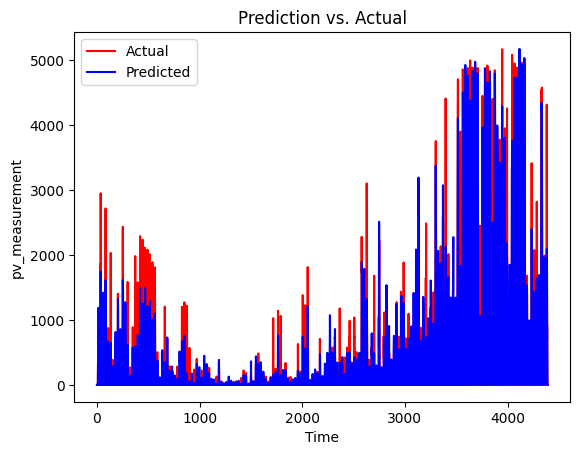

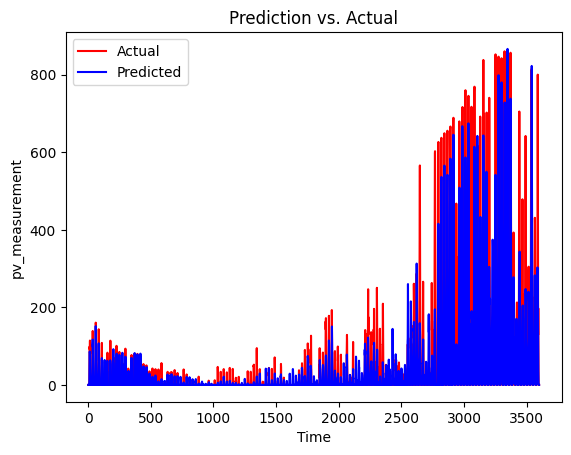

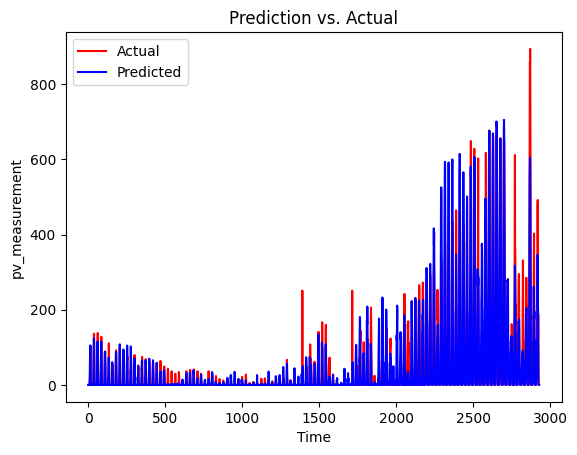

In [13]:
# Plotting Prediction vs. Actual
plt.plot(actual_values_a, label='Actual', color='red')
plt.plot(validation_a, label='Predicted', color='blue')
plt.xlabel('Time')
plt.ylabel('pv_measurement')
plt.title('Prediction vs. Actual')
plt.legend()
plt.show()

# Plotting Prediction vs. Actual
plt.plot(actual_values_b, label='Actual', color='red')
plt.plot(validation_b, label='Predicted', color='blue')
plt.xlabel('Time')
plt.ylabel('pv_measurement')
plt.title('Prediction vs. Actual')
plt.legend()
plt.show()

# Plotting Prediction vs. Actual
plt.plot(actual_values_c, label='Actual', color='red')
plt.plot(validation_c, label='Predicted', color='blue')
plt.xlabel('Time')
plt.ylabel('pv_measurement')
plt.title('Prediction vs. Actual')
plt.legend()
plt.show()

In [14]:
#meta_X = np.column_stack((validation_a., validation_b, validation_c))
#meta_model = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION)
#meta_model.fit(meta_X, y)
#combined_predictions = meta_model.predict(meta_X)

In [15]:
prediction_a = model_a.predict(A[2])
prediction_b = model_b.predict(B[2])
prediction_c = model_c.predict(C[2])

prediction_a[prediction_a < 0] = 0
prediction_b[prediction_b < 0] = 0
prediction_c[prediction_c < 0] = 0

submit = np.concatenate((np.concatenate((prediction_a, prediction_b)),prediction_c))

In [16]:
test = pd.read_csv('test.csv')

test

,id,time,prediction,location
0,0,2023-05-01 00:00:00,0,A
1,1,2023-05-01 01:00:00,0,A
2,2,2023-05-01 02:00:00,0,A
3,3,2023-05-01 03:00:00,0,A
4,4,2023-05-01 04:00:00,0,A
...,...,...,...,...
2155,2155,2023-07-03 19:00:00,0,C
2156,2156,2023-07-03 20:00:00,0,C
2157,2157,2023-07-03 21:00:00,0,C
2158,2158,2023-07-03 22:00:00,0,C


In [17]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission

,id,prediction
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
2155,2155,0
2156,2156,0
2157,2157,0
2158,2158,0


In [19]:
# Example, let the predictions be random values
test['prediction'] = submit
sample_submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
sample_submission.to_csv("catboost/catboost_1.csv", index=False)

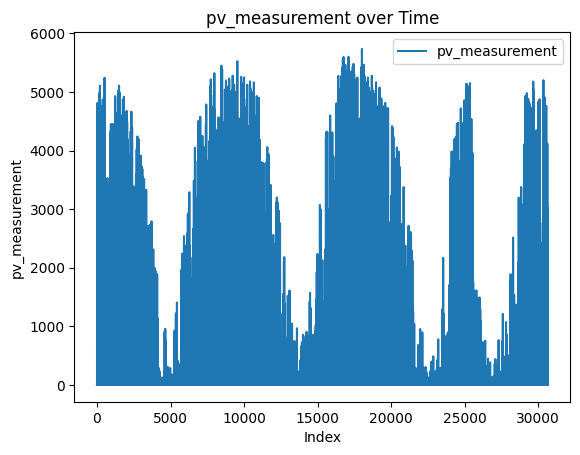

In [20]:
#Plot full sequence

pv_measurement_1 = A[0]['pv_measurement']

# Convert arr2 and arr3 to pandas Series
pv_measurement_2 = pd.Series(validation_a.flatten(), name='pv_measurement')
pv_measurement_3 = pd.Series(prediction_a.flatten(), name='pv_measurement')

# Concatenate the three Series
pv_measurement_combined = pd.concat([pv_measurement_1, pv_measurement_2, pv_measurement_3])

# Generate an index for the x-axis
index = range(len(pv_measurement_combined))

# Plot the data
plt.plot(index, pv_measurement_combined, label='pv_measurement')

# Add labels and title if needed
plt.xlabel('Index')
plt.ylabel('pv_measurement')
plt.title('pv_measurement over Time')

# Show the plot
plt.legend()
plt.show()

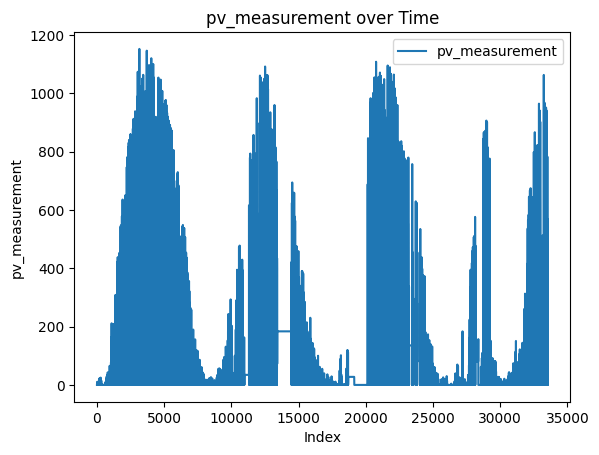

In [21]:
#Plot full sequence

pv_measurement_1 = B[0]['pv_measurement']

# Convert arr2 and arr3 to pandas Series
pv_measurement_2 = pd.Series(validation_b.flatten(), name='pv_measurement')
pv_measurement_3 = pd.Series(prediction_b.flatten(), name='pv_measurement')

# Concatenate the three Series
pv_measurement_combined = pd.concat([pv_measurement_1, pv_measurement_2, pv_measurement_3])

# Generate an index for the x-axis
index = range(len(pv_measurement_combined))

# Plot the data
plt.plot(index, pv_measurement_combined, label='pv_measurement')

# Add labels and title if needed
plt.xlabel('Index')
plt.ylabel('pv_measurement')
plt.title('pv_measurement over Time')

# Show the plot
plt.legend()
plt.show()

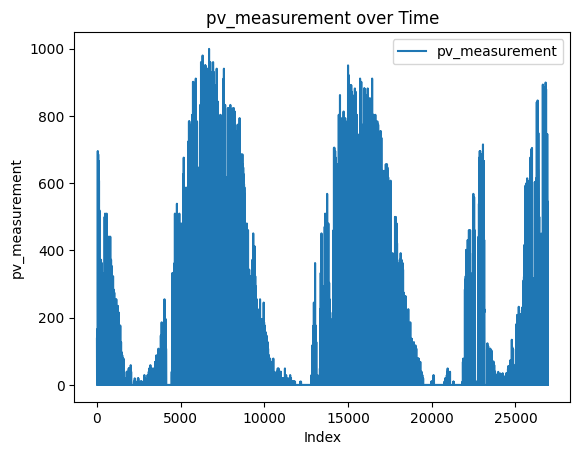

In [22]:
#Plot full sequence

pv_measurement_1 = C[0]['pv_measurement']

# Convert arr2 and arr3 to pandas Series
pv_measurement_2 = pd.Series(validation_c.flatten(), name='pv_measurement')
pv_measurement_3 = pd.Series(prediction_c.flatten(), name='pv_measurement')

# Concatenate the three Series
pv_measurement_combined = pd.concat([pv_measurement_1, pv_measurement_2, pv_measurement_3])

# Generate an index for the x-axis
index = range(len(pv_measurement_combined))

# Plot the data
plt.plot(index, pv_measurement_combined, label='pv_measurement')

# Add labels and title if needed
plt.xlabel('Index')
plt.ylabel('pv_measurement')
plt.title('pv_measurement over Time')

# Show the plot
plt.legend()
plt.show()